# Projet 1 - Classification Model

### Projet made by :
Cosmin Trandafir - 57101 | Martim Baptista - 56323 | João Serafim - 56376 | Martim Paraíba - 56273


#### In this project we will use dataset: ***biodegradable_a.cvs*** 

In [57]:
import pandas as pd
#Load biodegradable dataset
bio_df = pd.read_csv("biodegradable_a.csv")
#bio_df.info()

### Generic functions and Imports

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Function that prints classification scores

In [59]:
def classification_scores(y_test, y_pred):
    # Evaluate the performance of the model using various metrics
    print(classification_report(y_test, y_pred, target_names=['RB', 'NRB']))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Function that returns MCC score(used to compare scalers and imputers combinations)

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Returns mean crossvalidation score
def evaluate_model(imputer_tuple, scaler_tuple, classifier, X_train, X_test, y_train):
    imputer = imputer_tuple[1]
    # Impute missing values
    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    scaler = scaler_tuple[1]
    # Scale the test data
    scaler.fit(X_train_imputed)
    X_train_scaled = scaler.transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Train the classifier
    classifier.fit(X_train_scaled, y_train)
    preds = classifier.predict(X_test_scaled)
    
    mcc = matthews_corrcoef(y_test, preds)
    
    # Compute cross-validation scores
    cv_scores = cross_val_score(classifier, X_test_scaled, y_test, cv=10)
    mean_cv_score = cv_scores.mean()
    
    # lines of code that prints the classification scores of each imputer and scaler combination
    # MCC
    # print(f'\nImputer: {imputer_tuple[0]} \nScaler: {scaler_tuple[0]} \nMCC Score: {mcc}')
    # classification_scores(y_test, preds)
    # CrossValidation Scores
    # print("Imputer: {} \nScaler: {}\nCrossValidationScore: {:.6f}\n".format(imputer_tuple[0], scaler_tuple[0], mean_cv_score))
    
    return mcc


## Inicialization 

Encoding the RB and NRB classes to 0 and 1 values

In [61]:
from sklearn import preprocessing
# Divide Freatures and Class columns for preprocessing
X = bio_df.iloc[:, :-1]
y = bio_df.iloc[:, -1]

# Encode string classes to a numeric value
le = preprocessing.LabelEncoder()
df_encoded_classes = le.fit_transform(y)


### Data Imputation and Scaling


#### Combinations of 
##### Imputers: 
SimpleImputer with mean strategy, SimpleImputer with median strategy, KNNImputer with 3 nearest neighbors, KNNImputer with 5 nearest neighbors, KNNImputer with 7 nearest neighbors, KNNImputer with 9 nearest neighbors, KNNImputer with 11 nearest neighbors, IterativeImputer

##### With Scalers:
MinMaxScaler, StandardScaler, Normalizer, PowerTransformer

In [62]:
# X_search and y_search will be used to check the best imputer, scaler and selector, 
# X_final and y_final will be used in the end to test the selected pipeline
X_search, X_final, y_search, y_final = train_test_split(X, df_encoded_classes, test_size=0.2, random_state=0)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_search, y_search, test_size=0.33, random_state=42)
# List of imputers to test (imputer_name, imputer)
imputers =[("SI=mean", SimpleImputer(strategy='mean')), 
           ("SI=median", SimpleImputer(strategy='median')), 
           ("KNN3",KNNImputer(n_neighbors=3)), 
           ("KNN5",KNNImputer(n_neighbors=5)), 
           ("KNN7",KNNImputer(n_neighbors=7)), 
           ("KNN9",KNNImputer(n_neighbors=9)),
           ("KNN11",KNNImputer(n_neighbors=11)),
           # random state to use same iteration for different runs
           ("II",IterativeImputer(random_state=0))]

# List of scalers to test (scaler_name, scaler)
scalers = [("MinMax",MinMaxScaler()), 
           ("SS",StandardScaler()), 
           ("Norm",Normalizer()), 
           ("PT",PowerTransformer())]

# List of combinations of imputer and scaler names to user in graph
combos = [imputer_name + " + " + scaler_name for imputer_name, imputer in imputers for scaler_name, scaler in scalers]

# List of MCC scores for every combination of imputers and scalers
scores = []

for imputer in imputers:
    for scaler in scalers:
        # Storing scores in list
        # random state to use same iteration for different runs
        scores.append(evaluate_model(imputer, scaler, LogisticRegression(max_iter=10000, random_state=42), X_train, X_test, y_train))


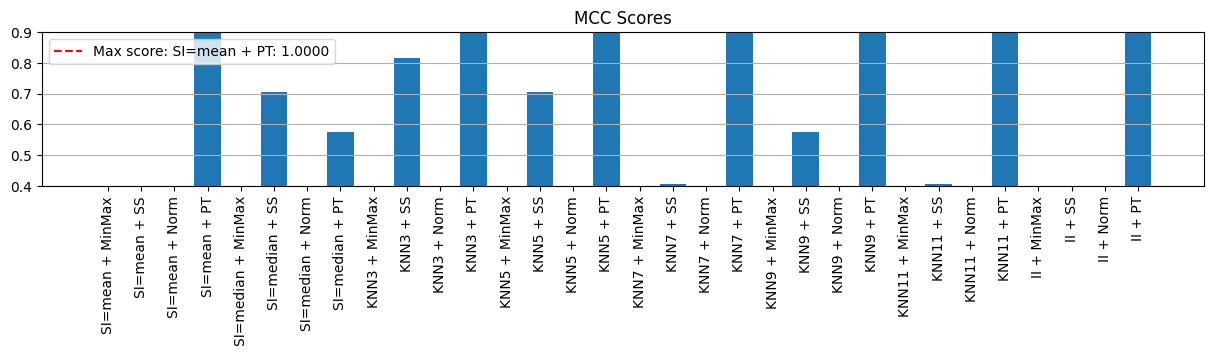

In [64]:
# figsize to adjust size 
fig, ax = plt.subplots(figsize=(15, 2))
ax.bar(combos, scores)
ax.set_title('MCC Scores')

# Set boundries for y axis 
ax.set_ylim([0.4, 0.9])
ax.grid(axis='y')

# Make labels visible
ax.set_xticklabels(combos, rotation=90, ha='center')

# Calculate and show line of max score
max_score_idx = np.argmax(scores)
highest_name, highest_score = combos[max_score_idx], scores[max_score_idx]
ax.axhline(y=scores[max_score_idx], color='r', linestyle='--', label='Max score')

ax.legend([f'Max score: {highest_name}: {highest_score:.4f}'])

plt.show()


## Feature Selection


#### Prepare dataset using best Imputer and Scaler
 

In [65]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Impute missing values
imputer = IterativeImputer(random_state=42)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)



#### Pearson Correlation between each feature and target classification

In [66]:
# Feature selection using Pearson correlation
corr_coef = np.corrcoef(np.hstack((y_train.reshape((-1, 1)), X_train_scaled)).T)

#Select features with correlation coeficient above 0 (coeficients between each feature and the classification)
corr_features_idx = np.where(corr_coef[0, 1:] > 0)[0]
X_train_corr = X_train_scaled[:, corr_features_idx]
X_test_corr = X_test_scaled[:, corr_features_idx]

print(f'{len(corr_features_idx)} features have a correlation above 0')

19 features have a correlation above 0


#### PCA

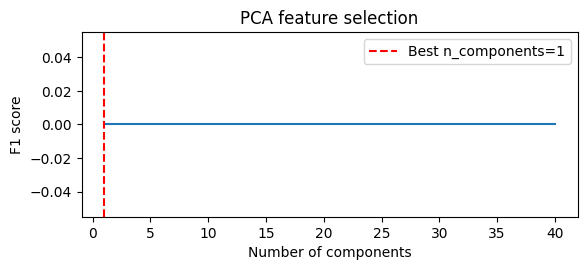

In [67]:
# Feature selection using PCA

# Define the range of number of components to test
n_components_range = range(1, 41)

# Evaluate the models using logistic regression with MCC score
lr = LogisticRegression(random_state=42)
mcc_scores = []
for n_components in n_components_range:
    # Feature selection using PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    lr.fit(X_train_pca, y_train)
    y_pred = lr.predict(X_test_pca)
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    
# Find the best value of n_components based on MCC score
best_n_components = n_components_range[np.argmax(mcc_scores)]

# Plot the results
plt.figure(figsize=(6.4,2.4))
plt.plot(n_components_range, mcc_scores)
plt.xlabel('Number of components')
plt.ylabel('F1 score')
plt.title('PCA feature selection')
plt.axvline(best_n_components, linestyle='--', color='r', label=f'Best n_components={best_n_components}')
plt.legend()
plt.show()


# Feature selection using PCA with optimal value of components
pca = PCA(n_components=best_n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### SelectKBest

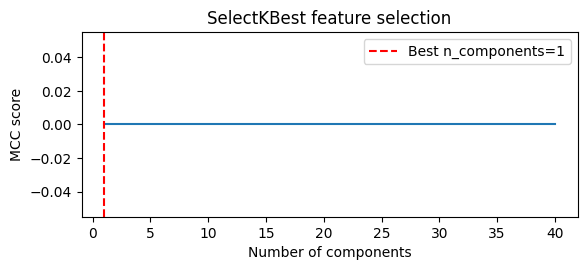

In [68]:
# Feature selection using SelectKBest 

# Define the range of number of components to test
n_components_range = range(1, 41)

# Evaluate the models using logistic regression with MCC score
lr = LogisticRegression(random_state=42)
mcc_scores = []
for n_components in n_components_range:
    # Feature selection using PCA
    kbest = SelectKBest(k=n_components)
    kbest.fit(X_train_scaled, y_train)
    X_train_kbest = kbest.transform(X_train_scaled)
    X_test_kbest = kbest.transform(X_test_scaled)

    lr.fit(X_train_kbest, y_train)
    y_pred = lr.predict(X_test_kbest)
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    
# Find the best value of n_components based on MCC score
best_n_components = n_components_range[np.argmax(mcc_scores)]

# Plot the results
plt.figure(figsize=(6.4,2.4))
plt.plot(n_components_range, mcc_scores)
plt.xlabel('Number of components')
plt.ylabel('MCC score')
plt.title('SelectKBest feature selection')
plt.axvline(best_n_components, linestyle='--', color='r', label=f'Best n_components={best_n_components}')
plt.legend()
plt.show()

kbest = SelectKBest(k=best_n_components)
kbest.fit(X_train_scaled, y_train)
X_train_kbest = kbest.transform(X_train_scaled)
X_test_kbest = kbest.transform(X_test_scaled)

#### SequentialFeatureSelection

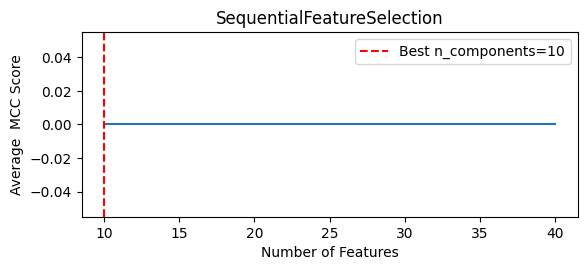

In [69]:
from sklearn.feature_selection import SequentialFeatureSelector
# Define a range of the number of features to consider(for performance purpose)
n_features_range = [10, 15, 20, 25, 30, 35, 40]

# Create an empty list to store the average cross-validation scores
mcc_scores = []
scorer = make_scorer(matthews_corrcoef)

clf = LogisticRegression(random_state=42, max_iter=10000)

# Iterate over the number of features and perform cross-validation for each number of features
for n_features in n_features_range:
    sfs = SequentialFeatureSelector(clf, n_features_to_select=n_features, scoring=scorer)
    sfs.fit(X_train_scaled, y_train)
    X_train_sfs = sfs.transform(X_train_scaled)
    X_test_sfs = sfs.transform(X_test_scaled)
    clf.fit(X_train_sfs, y_train)
    y_pred_sfs = clf.predict(X_test_sfs)
    mcc = matthews_corrcoef(y_pred_sfs, y_test)
    mcc_scores.append(mcc)
    

# Find the best value of n_components based on MCC score
best_n_components = n_features_range[np.argmax(mcc_scores)]

# Plot the average cross-validation scores against the number of features
plt.figure(figsize=(6.4,2.4))
plt.plot(n_features_range, mcc_scores)
plt.xlabel('Number of Features')
plt.ylabel('Average  MCC Score')
plt.title('SequentialFeatureSelection')
plt.axvline(best_n_components, linestyle='--', color='r', label=f'Best n_components={best_n_components}')
plt.legend()
plt.show()


In [70]:
#Optimal number of features is 35
sfs = SequentialFeatureSelector(clf, n_features_to_select=35, scoring=scorer)
sfs.fit(X_train_scaled, y_train)
X_train_sfs = sfs.transform(X_train_scaled)
X_test_sfs = sfs.transform(X_test_scaled)


#### Checking the best MCC score for the selectors
Also compared with no feature selection


In [71]:
# Evaluate the models using logistic regression with MCC score
lr = LogisticRegression(random_state=42)
models = [("Pearson", X_train_corr, X_test_corr),
          ("PCA", X_train_pca, X_test_pca),
          ("SelectKBest", X_train_kbest, X_test_kbest),
          ("SequentialFeatureSelection", X_train_sfs, X_test_sfs)]

# Printing MCC score without feature selectors
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Without feature selectors: MCC score = {mcc:.4f}")

# Printing MCC scores for feature selectors
for name, X_train_fs, X_test_fs in models:
    lr.fit(X_train_fs, y_train)
    y_pred = lr.predict(X_test_fs)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"{name} with: MCC score = {mcc:.4f}")

Without feature selectors: MCC score = 0.0000
Pearson with: MCC score = 0.0000
PCA with: MCC score = 0.0000
SelectKBest with: MCC score = 0.0000
SequentialFeatureSelection with: MCC score = 0.0000


#### Now onto selecting the best model

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Best Imputer, Scaler and Selector 
imputer = IterativeImputer(random_state=42)
scaler = StandardScaler()
selector = SequentialFeatureSelector(clf, n_features_to_select=35, scoring=scorer)

# Impute missing values
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Feature selection 
selector.fit(X_train_scaled, y_train)
X_train_kbest = selector.transform(X_train_scaled)
X_test_kbest = selector.transform(X_test_scaled)


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)

# Define grid of hyperparameters to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Perform grid search with cross-validation
scorer = make_scorer(matthews_corrcoef)
cv = GridSearchCV(dtc, param_grid=param_grid, scoring=scorer, cv=5)
cv.fit(X_train_kbest, y_train)

# Print the best hyperparameters and performance score
print("Best hyperparameters:", cv.best_params_)

# Evaluate the model with best hyperparameters on the test set
y_pred = cv.predict(X_test_kbest)

# Check classification scores
#print('\n')
#classification_scores(y_test, y_pred)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [74]:
from sklearn.metrics import classification_report

# create a Random Forest classifier object
rfc = RandomForestClassifier(random_state=42)

# define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create a GridSearchCV object
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring=scorer)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train_kbest, y_train)

# print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_kbest)

# Check classification scores
#classification_scores(y_test, y_pred)

Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [75]:
# Create a SVC classifier
svc = SVC(random_state=42)

# define the parameter grid to search over
param_grid = {
    "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
    "C": [0.01, 0.1, 1, 10, 100, 1000, 10000]
    }

# fit the GridSearchCV object to the training data
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring=scorer)
grid_search = grid_search.fit(X_train_kbest, y_train)

# print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_kbest)

# Check classification scores
#classification_scores(y_test, y_pred)

Best hyperparameters: {'C': 0.1, 'gamma': 0.01}


In [76]:
# Define the hyperparameters and their possible values
hyperparameters = {
    'C': [0.1, 1.0, 10.0],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization penalty type
    'solver': ['liblinear', 'saga'],  # Solver algorithm
    'max_iter': [100, 200, 500, 1000, 10000]  # Maximum number of iterations
}

# Create a logistic regression model
logistic_regression = LogisticRegression()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(logistic_regression, hyperparameters, cv=5, scoring=scorer)
grid_search.fit(X_train_kbest, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the validation set using MCC
y_pred = best_model.predict(X_test_kbest)
#classification_scores(y_test, y_pred)

Best hyperparameters: {'C': 10.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [77]:
from sklearn.neighbors import KNeighborsClassifier
#Create a KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scorer)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_kbest, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_kbest)

# Check classification scores
#classification_scores(y_test, y_pred)

Best hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


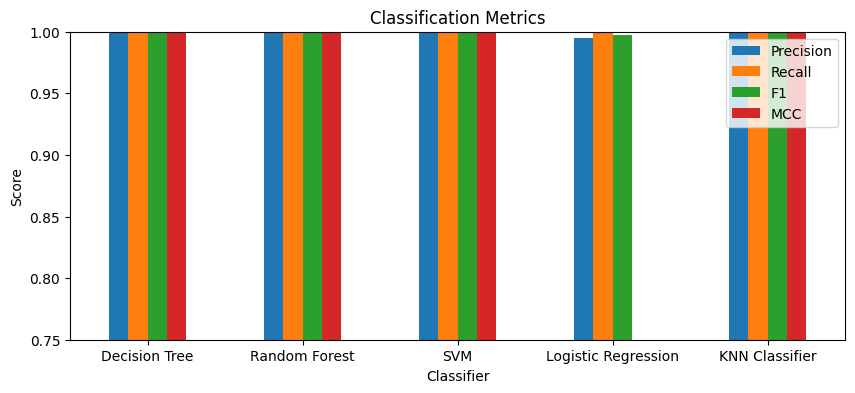

The best classifier is Decision Tree, with the MCC score of 1.00000


In [78]:
# define classifiers
classifiers = [('Decision Tree', DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4, min_samples_split=2, random_state=42)),
               ('Random Forest', RandomForestClassifier(max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=42)),
               ('SVM', SVC(C=100, gamma=0.1, random_state=42)),
               ('Logistic Regression', LogisticRegression(C=10.0, max_iter=500, solver='saga', penalty='l1', random_state=42)),
               ('KNN Classifier', KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]

# evaluate classifiers using precision, recall, f1, and MCC metrics
metrics = ['Precision', 'Recall', 'F1', 'MCC']
results = pd.DataFrame(columns=metrics, index=[name for name, clf in classifiers])

for name, clf in classifiers:
    clf.fit(X_train_kbest, y_train)
    y_pred = clf.predict(X_test_kbest)
    results.loc[name, 'Precision'] = precision_score(y_test, y_pred)
    results.loc[name, 'Recall'] = recall_score(y_test, y_pred)
    results.loc[name, 'F1'] = f1_score(y_test, y_pred)
    results.loc[name, 'MCC'] = matthews_corrcoef(y_test, y_pred)

# plot results
fig, ax = plt.subplots(figsize=(10, 2))
results.plot(kind='bar', ax=ax)
ax.set_ylim([0.75, 1.0])
ax.set_xlabel('Classifier')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics')
plt.xticks(rotation=0)
plt.show()

# print best classifier and its F1 score
results['MCC'] = results['MCC'].astype(float)
best_classifier = results['MCC'].idxmax()
best_score = results.loc[best_classifier, 'MCC']
print(f'The best classifier is {best_classifier}, with the MCC score of {best_score:.5f}')

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
# Create the pipeline
pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler()),
    ('feature_selector', SequentialFeatureSelector(clf, n_features_to_select=35, scoring=scorer)),
    ('classifier', SVC(C=100, gamma=0.1, random_state=42))
])


pipeline.fit(X_search, y_search)
y_pred_final = pipeline.predict(X_final)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(y_final, y_pred_final)
print("Matthews Correlation Coefficient:", mcc)

# Display classification report
report = classification_report(y_final, y_pred_final, target_names=['RB', 'NRB'])
print("Classification Report:")
print(report)

Matthews Correlation Coefficient: 1.0
Classification Report:
              precision    recall  f1-score   support

          RB       1.00      1.00      1.00         3
         NRB       1.00      1.00      1.00       910

    accuracy                           1.00       913
   macro avg       1.00      1.00      1.00       913
weighted avg       1.00      1.00      1.00       913

